# Optimizers, Hyperparameters, initializing parameters, weight decay/drop out ...

- 최적화에 사용되는 Optimizer에는 SDG 이외에도 여러가지가 있다. 경사하강법을 적절히 변형시킨 것들인데 학습목적에 맞는 것을 선택해야 한다.
- 학습 효율에 영향을 미치는 것들 중에서 학습 전에 조정해야 할 것들이 있다. Hyperparameter와 매개변수 초기화가 대표적이다.
- 학습 과정에서 오류를 발생시키는 것들 중 대표적인 것이 오버피팅 현상인데, 가중치 감소/드롭아웃 등의 정규화 기술이 있다.

## 1. Optimizers
대부분의 옵티마이저는 Gradient Descent 알고리즘의 다음 식을 변형한 것들이다. 
$$
\mathbf{W} \longleftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$
- $\eta$ : 학습률, $\mathbf{W}$ : 가중치 배열, $\frac{\partial L}{\partial \mathbf{W}}$ : 가중치에 대한 손실함수의 gradient
- 많은 손실이 날 수록(정답에서 많이 이탈할 수록, 경사가 심할 수록) 크게, 학습률에 비례하여, 손실이 줄어드는 방향으로, 가중치갱신이 일어난다.

### 1.1 SGD, Stochastic Gradient Descent
무작위로 미니배치를 선정하여 GD 하는 방식이다. 지금까지의 예제에서 사용했던 학습방법이다.
- 기울기에 따라 변동이 심하므로 학습 효율도 변동이 심하다.
- 비등방성anisotropy 함수의 경우 (예를 들어, $f(x,y) = \frac{1}{20} x^2 + y^2$)  탐색 방향에 따라 최적화 경로가 비효율적이 된다.
- plateau 에서 학습이 정체되기도 하는 단점이 있다.
- local minima를 벗어나지 못하고 학습이 멈추는 단점이 있다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")


In [47]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

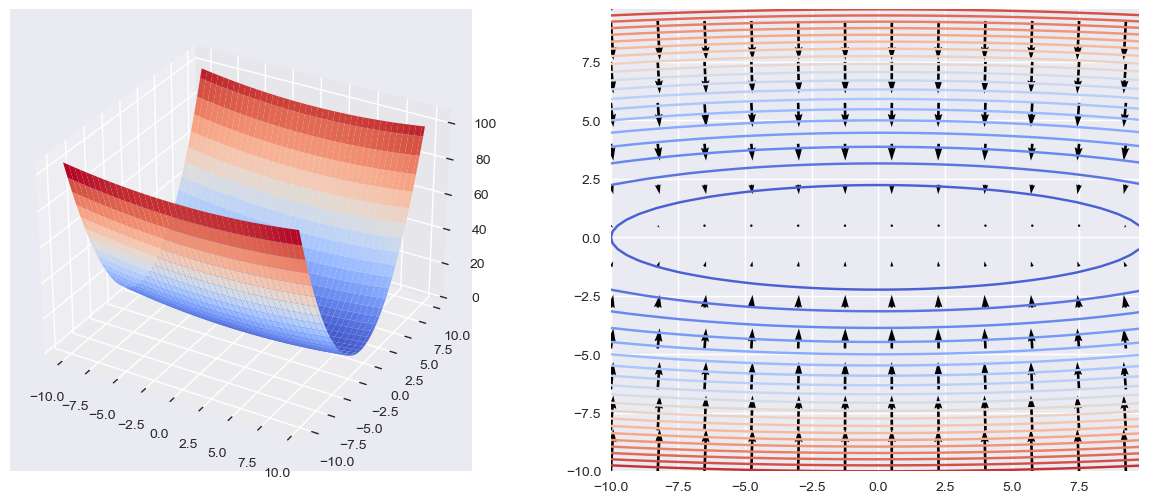

In [48]:
%matplotlib inline
f = lambda x, y: 1/20 * x**2 + y**2
f_ = lambda X: 1/20 * X[0]**2 + X[1]**2

x = np.arange(-10, 10, 0.25)
y = x.copy()
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

cmap = plt.get_cmap('coolwarm')
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X, Y, Z, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.contour(X,Y, Z, 20, cmap=cmap)

from common.functions import num_gradient, num_gradient_without_batch
step = 7
X, Y = X[::step, ::step], Y[::step, ::step] 
pts = np.vstack((X.flatten(), Y.flatten())).T
dx, dy = num_gradient(f_, pts).T
ax2.quiver(X, Y, -dx, -dy, angles='xy', scale=250)
plt.show()

### 1.2 Momentum
위에서 보듯 가로축방향으로의 학습이 매우 비효율적임을 알 수 있다. 그래서 기울기의 누적치에 역비례하도록 학습량을 조정(누적된 기울기값이 클 수록 학습량은 작아지도록)하게 되는데 아래의 알고리즘을 가지는 Momentum이 그렇게 설계되었다.  
$$\begin{align*}
v &\longleftarrow -\Big(\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v \Big) =\alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} &\longleftarrow \mathbf{W} + v 
\end{align*}$$
- $k$ 단계까지 거슬러 올라가 보면 다음과 같이 전개할 수 있다.
$$\begin{align*}
\mathbf{W}_{n+1} &= \mathbf{W}_n + v_n = \mathbf{W}_n + \Big(\alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}_{n}} \Big) \\
&= \mathbf{W}_n + \Big(\alpha \Big(\alpha (v_{n-2} - \eta\frac{\partial L}{\partial \mathbf{W}_{n-1}})\Big) - \eta\frac{\partial L}{\partial \mathbf{W}_{n}} \Big) \\
& \vdots \\
&= \mathbf{W}_n + \alpha^k v_{n-k} - \eta\sum_{i=1}^k \alpha^{i-1}\frac{\partial L}{\partial \mathbf{W}_{n-i+1}}  \\
&= \mathbf{W}_n + \alpha^n v_{0} - \eta\sum_{i=1}^n \alpha^{i-1}\frac{\partial L}{\partial \mathbf{W}_{n-i+1}} \\
&= \mathbf{W}_n - \eta\sum_{i=1}^n \alpha^{n-i}\frac{\partial L}{\partial \mathbf{W}_{i}} 
\end{align*}$$
- SGD는 현재 그래디언트값만이 갱신에 영향을 주는 반면, 모멘텀은 과거의 누적 갱신값이 현재 파라미터 갱신에 지수계수선형적으로($- \eta\sum_{i=1}^n \alpha^{n-i}\frac{\partial L}{\partial \mathbf{W}_{i}}$)영향을 주는 구조임을 알 수 있다. 
- 그래서 모멘텀이란 이름이 붙여졌는데, 관성Inertia(누적된 과거의 갱신값)을 고려한 결과 관성력에 의해 로컬 최적점을 지나쳐 학습이 이루어지도록 하여 SGD의 문제였던 로컬 극값에서 학습중단이 일어나는 확률을 줄이고 더 나은 최적점을 학습을 할 수 있는 가능성을 높인다.
- $\alpha$ 가 클 수록 학습 갱신에 저항(누적된 과거의 영향력)을 많이 받는다. 즉, 학습이 작은 스텝으로 이루어진다. 
- 물리학에서의 모멘텀처럼 $\alpha$ 를 질량 $v$ 를 속도로 하여 해석하면 $\alpha v$는 momentum 에 대응한다.
- 물론 $\alpha v$ 를 속도에 비례하는 저항력(damping force) 또는 저항모멘텀으로도 해석한다. 그래서 $\alpha < 1$ 이 되도록 설정한다.
- 요지는 질량이 클 수록 가속 $\frac{\partial L}{\partial \mathbf{W}}$ 에 따른 속도변화가 작듯이 학습 진행도 그렇게 되도록 설계되었다.
- 학습 갱신량 ($\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v$) 이 현재속도($v$) 에 역비례($-\alpha$) 하고 최적점 근처에서의 속도가 가장 크므로 최적점에 가까울 수록 갱신량이 줄어든다.

In [49]:
class Momentum:
    def __init__(self, lr=0.01, alpha=0.9) -> None:
        self.lr = lr      # learning rate
        self.v = None          # velocity
        self.alpha = alpha  # mass
    def update(self, params, grads):
        if self.v is None:  # v == 0 at starting point
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.alpha*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

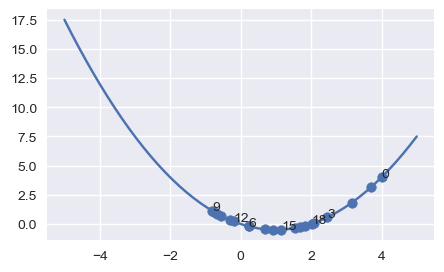

In [50]:
x = np.linspace(-5, 5)
f = lambda x: 0.5*x**2  - x
df = lambda x: x - 1
init = 4.0
params = {}
params['x'] = np.array([4.]) 
grads = {}
grads['x']  = 0
x_hist = []

mom = Momentum(lr=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.3 Nesterov Accelerated Gradient, NAG
Nesterov Momentum은 현재 속도($v$) 대신에 현재 기울기로 계산된 다음 다음 속도를 저항속도로 사용하는 모멘텀이다. 즉,
$$
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \longleftarrow \mathbf{W} +  v
$$
한 단계로 풀이하면,
$$
\mathbf{W} \longleftarrow \mathbf{W} + \alpha \Big(\alpha (\alpha v -\eta \frac{\partial L}{\partial \mathbf{W}}) - \eta \frac{\partial L}{\partial \mathbf{W}}\Big) -\eta \frac{\partial L}{\partial \mathbf{W}}
$$

- Damping oscillation 운동을 하는 모멘텀 옵티마이저는 관성으로 인해 최적점을 지나쳐 가게 되어 있다. Nestrov 모멘텀의 경우 이 문제를 조금 줄일 수 있다.
- 아이디어는 다음과 같다. 파라미터 스페이스에서 모멘텀 옵티마이저보다 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향으로 옵티멈에 더 가깝게 파라미터를 옮기는 것이다. 최적점은 그것이 가리키는 방향에 존재할 것이기 때문이다. 
$$\begin{align*}
v_n &\longleftarrow \alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}} \Big|_{\mathbf{W} = \mathbf{W}_n + \alpha v_{n-1}} \\
\mathbf{W}_{n+1} &\longleftarrow \mathbf{W}_n + v_n
\end{align*}$$
- 이렇게 구성하면, $\mathbf{W}$ 점, $\alpha v$ 점, 기울기벡터 $ -\eta\frac{\partial L}{\partial \mathbf{W}}$ 의 연장선상에 있을 최적점의 삼각형을 떠올리면 알 수 있듯, Momentum에서의 평행사변형 꼴의 대각선  보다 더 가까워지긴 하지만, $\mathbf{W}$ 를 $\mathbf{W}_n + \alpha v_{n-1}$ 으로 변경하여 구해야 하므로 불필요한 임시 가중치를 중복계산하게 되는 번거로움이 생긴다. 그래서,
- 가중치는 변경하지 말고 $v$를 누적해서 (2번 더) 구함으로서 벡터를 기울기방향으로 더 기울어지도록 하는 방법을 사용한다. 즉, 벡터합의 평행사변형 꼴을 기울기 벡터 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향으로 더 납작하게 하는 것이다. 처음의 식처럼 말이다.![](NAG.png)

In [51]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. 
    
    def __init__(self, lr=0.01, alpha=0.9):
        self.lr = lr
        self.alpha = alpha
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.alpha
            self.v[key] -= self.lr * grads[key]
            params[key] += self.alpha * self.alpha * self.v[key]
            params[key] -= (1 + self.alpha) * self.lr * grads[key]

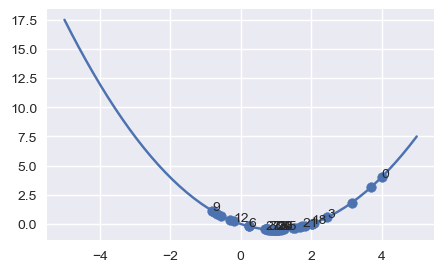

In [52]:
mom = Nesterov(lr=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.4 AdaGrad
- 처음에는 큰 폭으로 학습하다가 최적점 가까이서는 작은 폭으로 학습하는 **학습률 감소 learning rate decay** 기술을 적용한 optimizer.
- 개별 매개변수에 적응적adaptive 학습률을 조정하면서 학습을 진행한다.
$$\begin{align*}
\mathbf{h} &\longleftarrow \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} &\longleftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}}\frac{\partial L}{\partial \mathbf{W}}
\end{align*}$$

- $\mathbf{h}$는 개별 원소의 $\ell^2$-norm 제곱의 누적합 행렬이다. 따라서 gradient 누적 크기에 반비례하는 학습률로 학습하게 된다.
- 무한히 학습하는 과정에서 과거의 기울기를 제곱하여 계속 더해가므로 갱신강도가 약해져서 어느 순간 갱신이 안되는 문제가 있다.

### 1.5 RMSProp
- AdaGrad의 이런 문제를 해결하기 위한 기법이다.
- 과거의 기울기를 균일하게 더해가는 것이 아니라 과거보다 현재의 기울기를 크게 반영하도록 **지수이동평균Exponential Moving Average** 기법을 적용해 기하급수적으로 과거 기울기정보를 감소시키는 방식을 사용한다.
$$\begin{align*}
\mathbf{h} &\leftarrow \left(1 - \alpha \right)\mathbf{h} +  \alpha \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}\\
\mathbf{W} &\leftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}
\end{align*}$$

In [53]:
w1 = np.random.randint(-9, 10, (3, 4)).astype(np.float32)
w1 / (np.sqrt(w1 * w1) + 1e-7)

array([[ 1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.],
       [ 1.,  1., -1.,  1.]], dtype=float32)

In [54]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

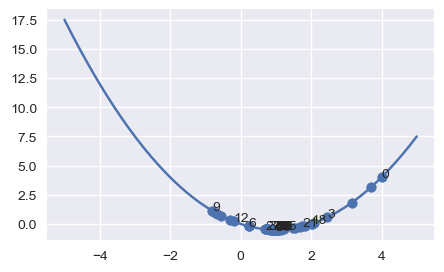

In [55]:
mom = AdaGrad(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

In [56]:
class RMSprop:
    """
    RMSprop은 AdaGrad 에서 h 갱신 부분을 decay_rate으로 웨이팅 처리 해준 것만 다르다.
    즉, AdaGrad에서는 h <- h + grads * grads 로 갱신되던 감소팩터 h를, 
    RMSprop에서는 h <- (decay_rate) * h + (1 - decay_rate) * grads * grads 로 웨이팅
    처리하여 현재와 과거의 비중을 달리 하여 감소팩터 h를 결정한다.
    """

    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) 

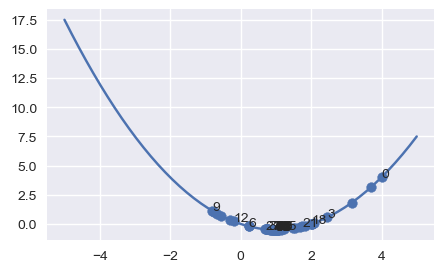

In [57]:
mom = RMSprop(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.6 Adam
- momentum은 과거 데이터를 반영하여 학습률을 조정하는 이점이 있었고, AdaGrad는 매개변수의 원소마다 적응적으로 갱신강도를 조정하는 이점이 있었는데, 이 두 가지 이점을 살려 결합한 것이 Adam 이라 할 수 있다.
- 또한 하이퍼파라미터의 '편향 보정'이 진행된다는 특징이 있다.
![Adam pseudo code](./adam_optimizer.png)
- 계산 과정:
**while** $\theta_{t}$ not converged **do**:  
  1) $\quad t \leftarrow  t + 1$  
  2) $\quad g_t \leftarrow \nabla_{w}L_{t}(\omega_{t-1}) $    
  3) $\quad m_t \leftarrow \beta_{1}\cdot m_{t-1} + (1 - \beta_{1})\cdot g_t$  
  4) $\quad v_t \leftarrow \beta_{2}\cdot v_{t-1} + (1 - \beta_{2})\cdot g^{2}_{t}$  
  5) $\quad \hat{m}_{t} \leftarrow \frac{m_t}{1 - \beta^{t}_1}$  
  6) $\quad \hat{v}_{t} \leftarrow \frac{v_t}{1 - \beta^{t}_2}$  
  7) $\quad \omega_t \leftarrow \omega_{t-1} - \frac{\mu \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$
  
  - 2) Get gradients at timestep t
  - 3) Update biased first moment estimate(Momentum)
  - 4) Update biased second raw moment estimate(RMSprop)
  - 5) Compute bias-corrected first moment estimate  
        1에 가까운  $\beta$ 값으로 편향된 first moment estimate을 보정한다.
  - 6) Compute bias-corrected second raw moment estimate
  - 7) Update parameter


### optimizers의 계보
| |SGD| |
|:--:|:--:|:--:|
|$\swarrow$||$\searrow$|
|모멘텀 적용| |학습률 조정|
|momentum||AdaGrad|
|$\downarrow$||$\downarrow$|
|NAG||RMSprop|
|$\searrow$||$\swarrow$|
||Adam||

In [58]:
class Adam:

    """
    Adam (http://arxiv.org/abs/1412.6980v8)
    Require: lr: stepsize, or learning rate
    Require: beta1, beta2 \in [0, 1): exponential decay rate for the moment estimates
    Require: L(w): Stochastic objective function with parameters w
    Require: w0 : initial parameter vector
             m0 <- 0 (initialize 1st moment vector)
             v0 <- 0 (initialize 2nd moment vector)
             t  <- 0 (initialize timestep)              
    """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        # moment estimates의 지수감소율
        self.beta1 = beta1  
        self.beta2 = beta2  
        
        self.iter = 0       # Stepsize counter
        
        self.m = None       # 1st moment vector
        self.v = None       # 2nd moment vector
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        # 논문의 alpha
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key]) # 3
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key]) # 4
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


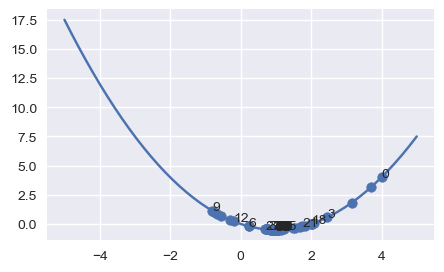

In [59]:
mom = Adam(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

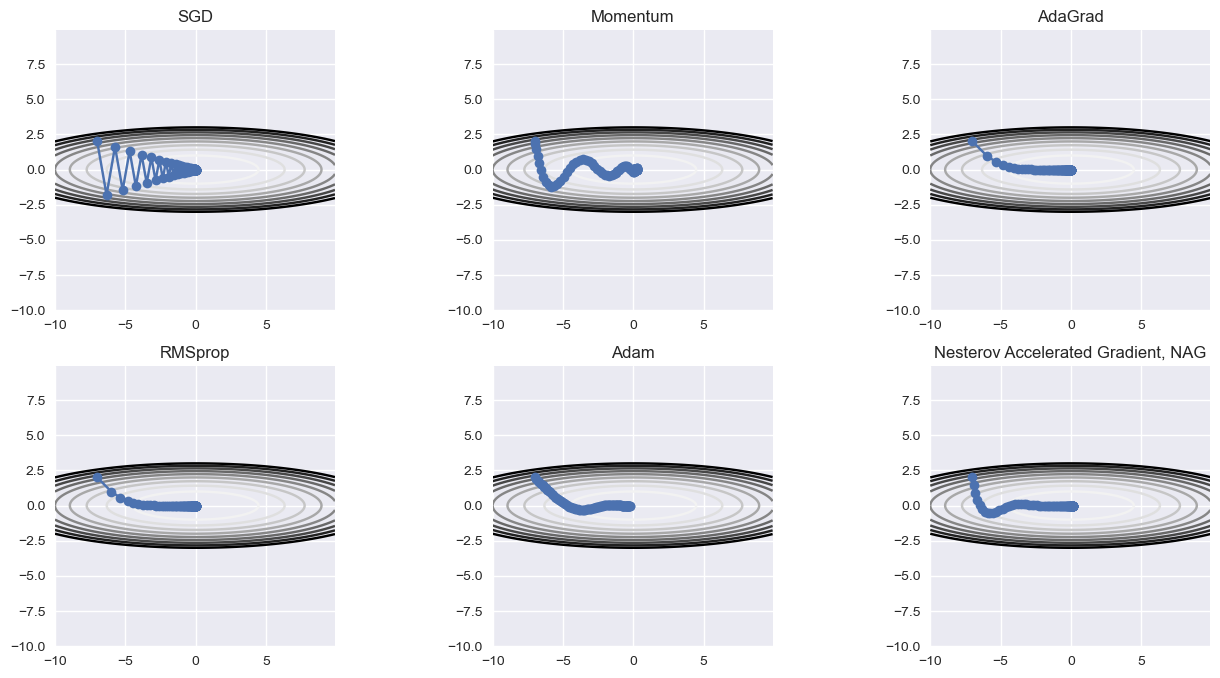

In [60]:
# Optimizers 비교하여 보기
f = lambda x, y: 1/20*x**2 + y**2

xline = np.arange(-10, 10, 0.1)
yline = xline.copy()
X, Y = np.meshgrid(xline, yline)
Z = f(X, Y)

# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}

# 여기서는 SGD를 사용한다.
optimizer = SGD(lr=.95)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# SGD 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   
      
    
fig = plt.figure(figsize=(16,8))

ax4 = fig.add_subplot(231)
ax4.contour(X, Y, Z, np.arange(0, 10, 1))
ax4.set_aspect('equal')
ax4.plot(params_list[0], params_list[1], marker='o')
ax4.set_title("SGD")






# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}

# 여기서는 Momentum을 사용한다.
optimizer = Momentum(lr=0.05)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)  # 갱신
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   


ax5 = fig.add_subplot(232)
ax5.contour(X, Y, Z, np.arange(0, 10, 1))
ax5.set_aspect('equal')
ax5.plot(params_list[0], params_list[1], marker='o')
ax5.set_title("Momentum")

# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}
# NAG 를 사용한다.
optimizer = Nesterov(lr=0.05)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)  # 갱신
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   


ax9 = fig.add_subplot(236)
ax9.contour(X, Y, Z, np.arange(0, 10, 1))
ax9.set_aspect('equal')
ax9.plot(params_list[0], params_list[1], marker='o')
ax9.set_title("Nesterov Accelerated Gradient, NAG")

# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}

# 여기서는 AdaGrad을 사용한다.
optimizer = AdaGrad(lr=1)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   

ax6 = fig.add_subplot(233)
ax6.contour(X, Y, Z, np.arange(0, 10, 1))
ax6.set_aspect('equal')
ax6.plot(params_list[0], params_list[1], marker='o')
ax6.set_title("AdaGrad")

# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}

# 여기서는 RMSprop을 사용한다.
optimizer = RMSprop(lr=.1, decay_rate=0.99)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   

ax7 = fig.add_subplot(234)
ax7.contour(X, Y, Z, np.arange(0, 10, 1))
ax7.set_aspect('equal')
ax7.plot(params_list[0], params_list[1], marker='o')
ax7.set_title("RMSprop")

# 파라미터 x, y 를 최적화(여기서는  z값 극소화)시키는 것이 목표이다.
# params와 grads 는 책에서 주어진 대로 dict타입을 취했다.
init_p = np.array([-7, 2], dtype='float')
params = {'W1': init_p}
grad = lambda x, y: (1/10*x, 2*y) # gradient 일반식
grads = {'W1': np.array(grad(*params['W1']), dtype='float')}

# 여기서는 Adam을 사용한다.
optimizer = Adam(lr=0.11)

iter_num = 99
params_list = np.zeros((2,iter_num + 1), dtype='float')
# 갱신되는 지점 저장하기 전에 초기값부터 저장한다. (2, iter_num+1)
params_list[:, 0] = params['W1']
for i in range(iter_num):
    optimizer.update(params, grads)
    new_param = params['W1']
    params_list[0][i+1] = new_param[0]
    params_list[1][i+1] = new_param[1]
    grads['W1'] = np.array(grad(*params['W1']))   

ax8 = fig.add_subplot(235)
ax8.contour(X, Y, Z, np.arange(0, 10, 1))
ax8.set_aspect('equal')
ax8.plot(params_list[0], params_list[1], marker='o')
ax8.set_title("Adam")
plt.show()

===========iteration:0===========
SGD:2.307302658322058
Momentum:2.472196841784738
AdaGrad:2.0985645017925156
Adam:2.2558809542249865
===========iteration:100===========
SGD:1.5190807786552298
Momentum:0.3224455686028185
AdaGrad:0.2147304071918547
Adam:0.20416285299531084
===========iteration:200===========
SGD:0.8363574733062271
Momentum:0.3248976391644683
AdaGrad:0.15128393349340857
Adam:0.2478194248780666
===========iteration:300===========
SGD:0.5153368180471577
Momentum:0.24081014967889208
AdaGrad:0.10588276976102888
Adam:0.11059363083817281
===========iteration:400===========
SGD:0.4949710921105235
Momentum:0.2877431321716181
AdaGrad:0.09153580496923333
Adam:0.20466384504194673
===========iteration:500===========
SGD:0.38711325464214635
Momentum:0.25200813140817657
AdaGrad:0.08391654289900338
Adam:0.17602857008650954
===========iteration:600===========
SGD:0.31931225505674155
Momentum:0.1664931147866049
AdaGrad:0.0793186305657227
Adam:0.0753314016504012
===========iteration:700==

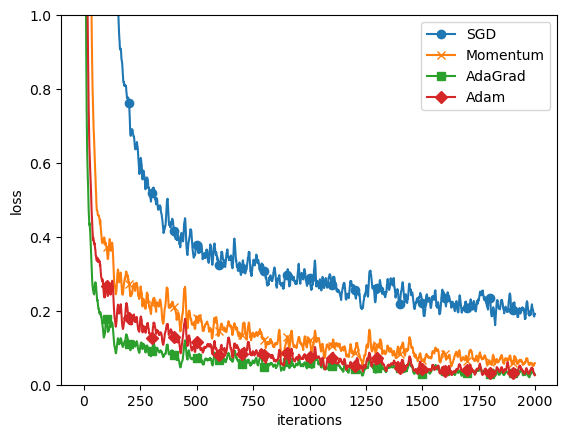

In [1]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [7]:
np.array([2.1, 3.2]).dtype

dtype('float64')

## 2. 가중치의 초기값
- 신경망 학습 성패가 갈리는 중요한 요인.
- 초기값을 0으로 하면(또는 균일한 값으로 설정하면) 오차역전파과정에서 모든 가중치 값이 똑같은 값으로 갱신되므로 가중치를 여럿 두는 의미가 사라진다.
- 따라서 고른 가중치가 나오는 결과를 피하기 위해 초기값을 무작위로 설정한다.
### 2.1 가중치 감소 Weight decay 기법
- 오버피팅을 억제하여 범용 성능을 높인다.
- 가중치 매개변수의 값이 작아지도록 학습하는 방법이다.
- 따라서 초기값도 작은 값에서 시작한다.
### 2.2 은닉층의 활성화값(계층 사이를 흐르는 데이터) 분포
- 데이터가 처리되는 과정의 중요한 정보를 얻기 위해서 활성화값 분포를 살펴본다.
- 레이블에 대응하는 예측값 분포를 히스토그램으로 나타낸다.

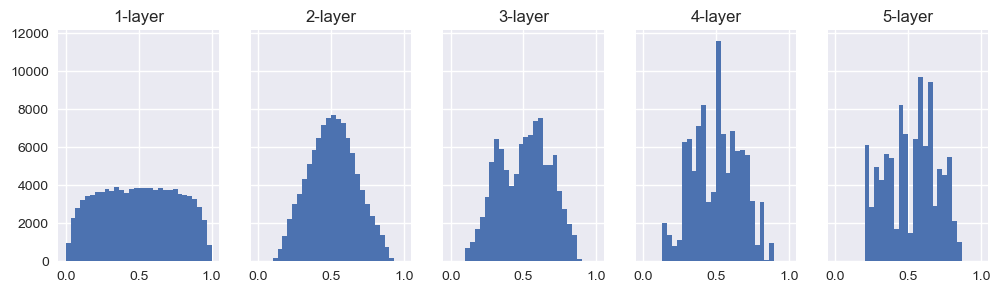

In [10]:
# 초기값 실험
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수, 출력 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
# histogram
fig, axs = plt.subplots(1, len(activations), figsize=(12,3), sharey=True)
for i, a in activations.items():    
    axs[i].set_title(str(i+1) + "-layer")
    axs[i].hist(a.flatten(), 30, range=(0, 1))
    
plt.show() # 기울기 소실 vanishing gradient
# for i, a in activations.items():
#     plt.subplot(1, len(activations), i+1)
#     plt.title(str(i+1) + "-layer")
#     if i != 0: plt.yticks([], [])
#     # plt.xlim(0.1, 1)
#     # plt.ylim(0, 7000)
#     plt.hist(a.flatten(), 30, range=(0,1))
# plt.show()

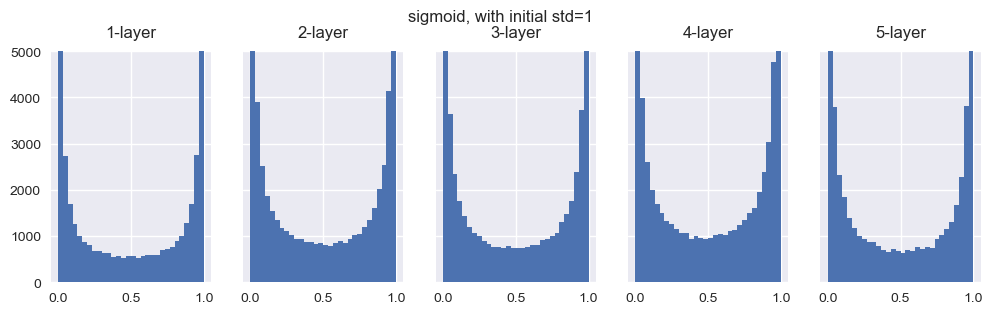

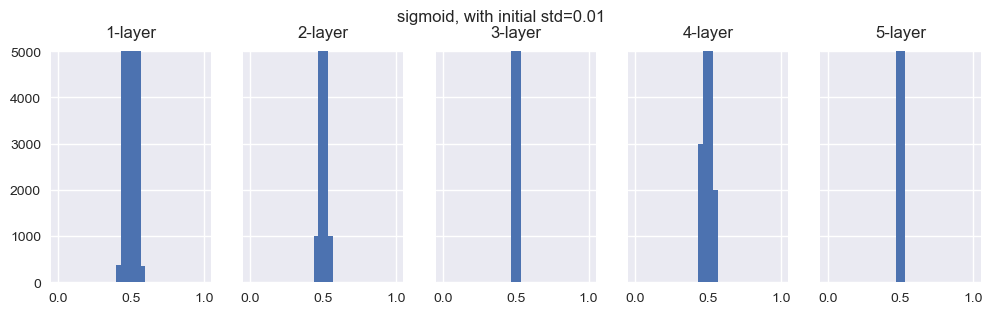

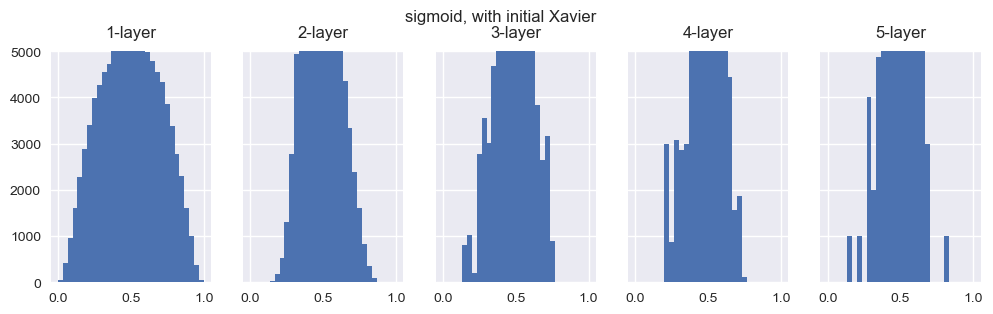

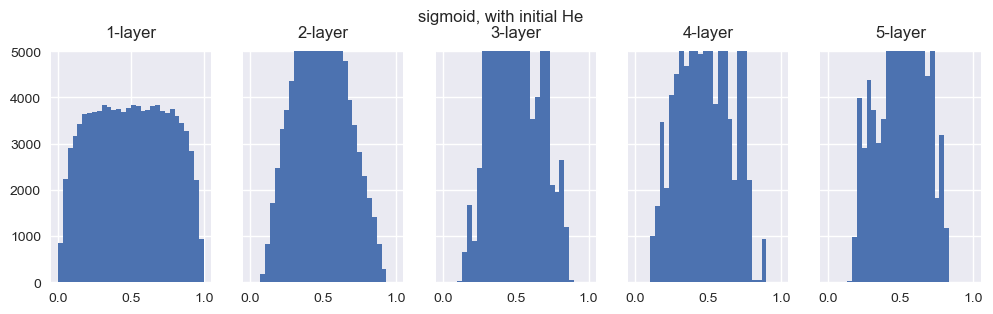

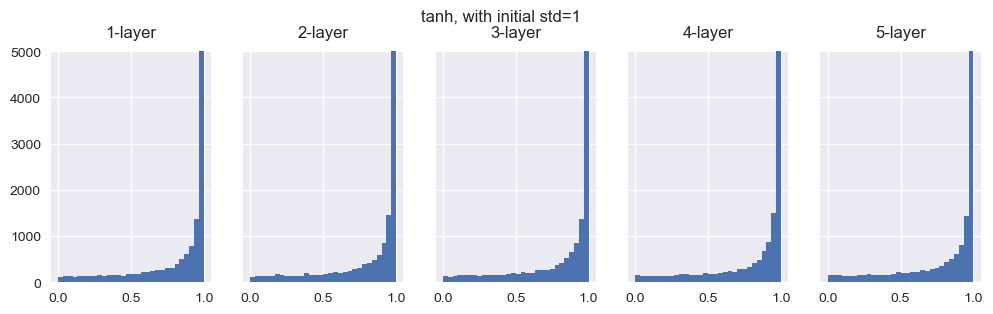

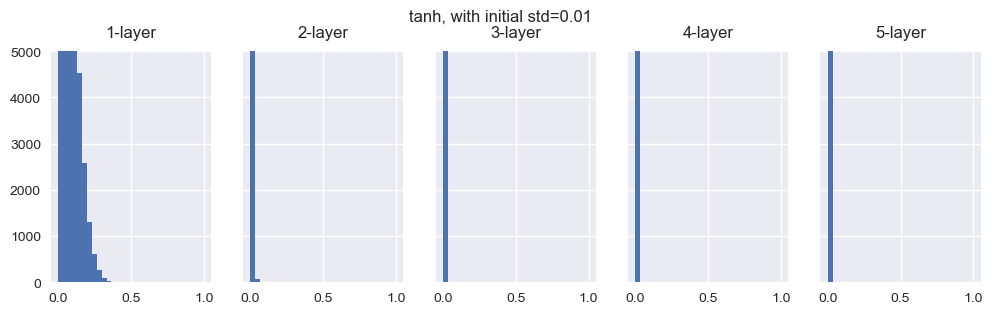

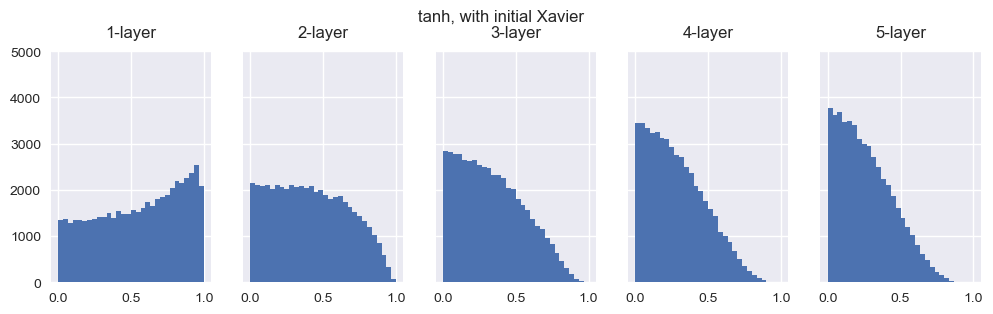

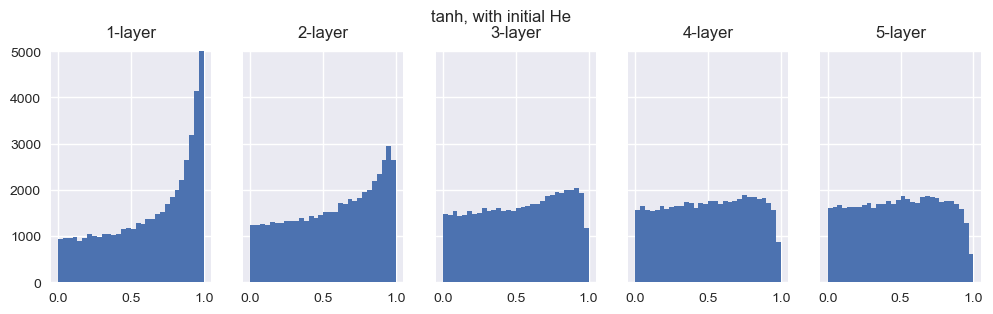

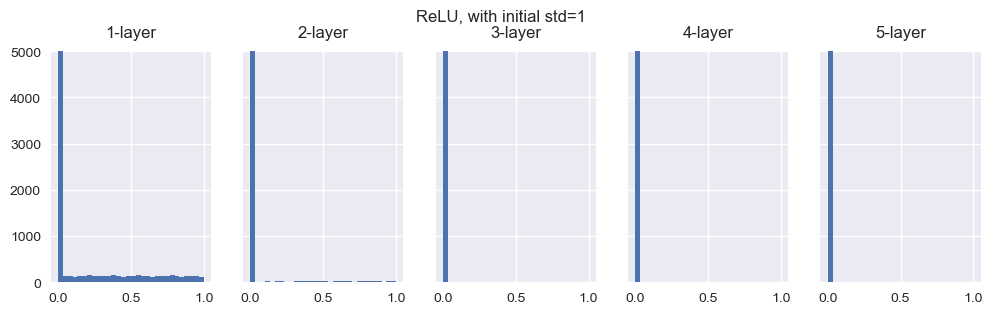

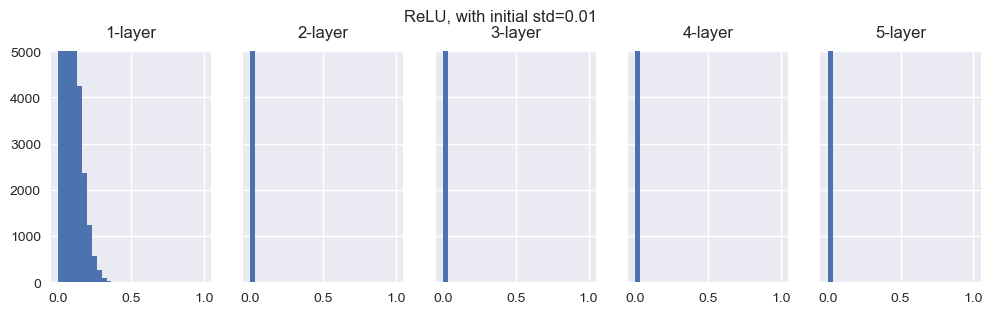

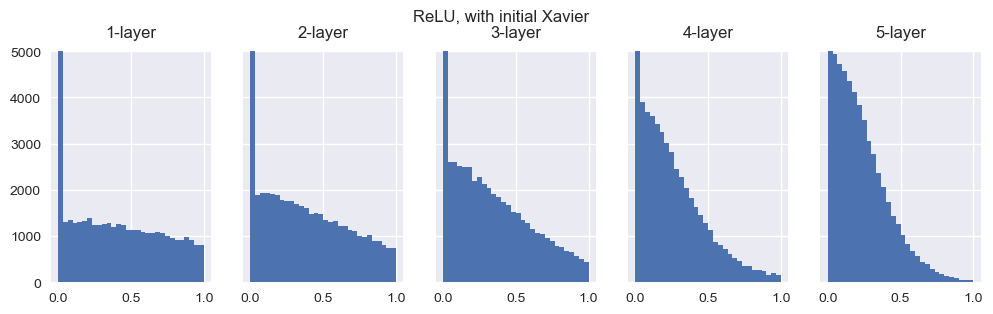

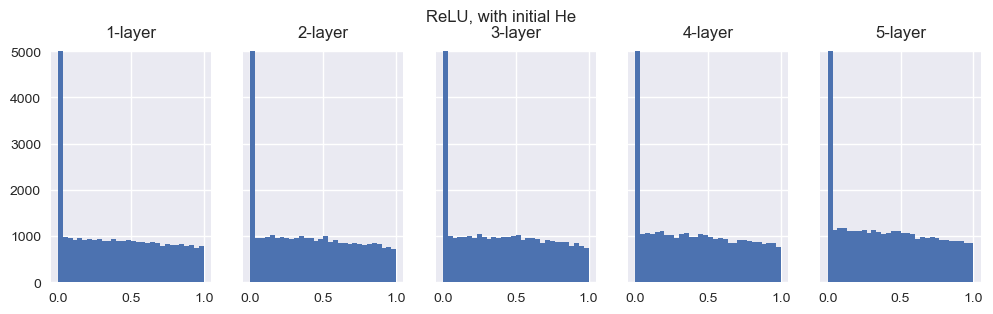

In [63]:
input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

activation_fnc = {
    "sigmoid": lambda x: sigmoid(x),
    "tanh": lambda x: tanh(x),
    "ReLU": lambda x: ReLU(x),
}
initial_deviations = {
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    "std=1": 1,
    "std=0.01": 0.01,
    "Xavier": np.sqrt(1.0 / node_num), # Xavier
    "He": np.sqrt(2.0 / node_num) # He
}


for f in activation_fnc.keys():
    
    for dev in initial_deviations.keys():
        x = input_data # 초기 설정별로 같은 값으로 유지

        for i in range(hidden_layer_size):
            if i != 0:
                x = activations[i-1]
            w = np.random.randn(node_num, node_num) * initial_deviations[dev] # layer마다 랜덤생성
            a = np.dot(x, w)
            z = activation_fnc[f](a)
            activations[i] = z
        # histogram
        fig, axes = plt.subplots(1, len(activations), figsize=(12, 3), sharey=True)
        fig.suptitle(f"{f}, with initial {dev}", va='baseline')
        for i, a in activations.items():
            axes[i].set_title(str(i+1) + "-layer", pad=10)
            axes[i].hist(a.flatten(), 30, range=(0, 1))
            axes[i].set_ylim(0, 5000)
plt.show()

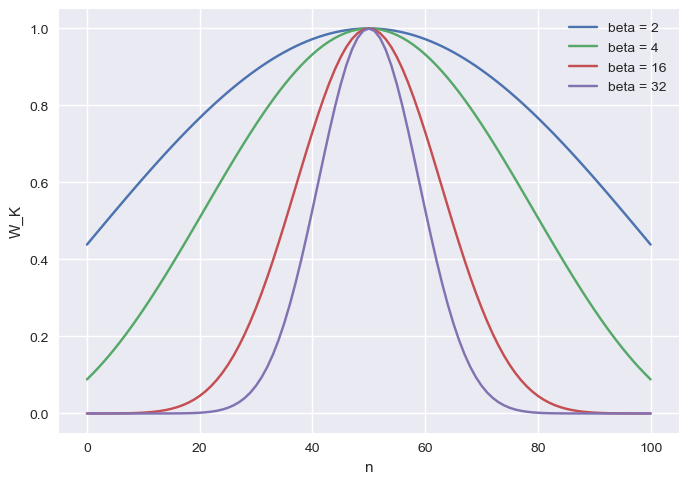

In [3]:
# smoothing and numpy convolve
# https://glowingpython.blogspot.com/2012/02/convolution-with-numpy.html
import pylab
beta = [2, 4, 16, 32]

pylab.figure()
for b in beta:
    w = np.kaiser(101, b)
    pylab.plot(range(len(w)), w, label="beta = "+ str(b))
pylab.xlabel('n')
pylab.ylabel('W_K')    
pylab.legend()
pylab.show()

In [8]:
def smooth(x, beta):
    """ kaiser window smoothing """
    window_len = 11
    # extending the data at beginning and the the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, beta)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]    

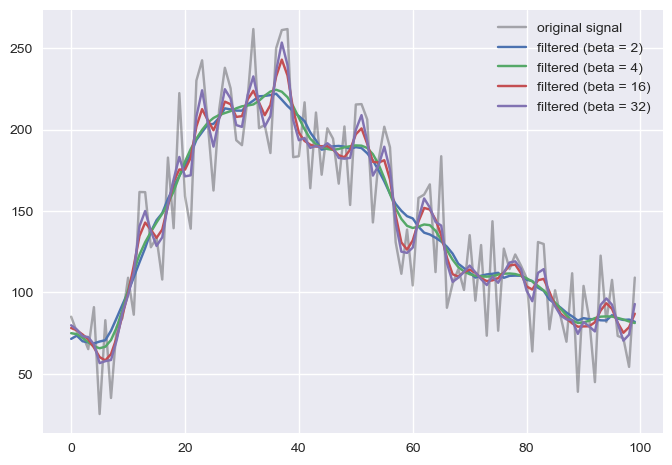

In [9]:
# random data generation
y = np.random.random(100)*100 
for i in range(100):
 y[i]=y[i]+i**((150-i)/80.0) # modifies the trend

# smoothing the data
pylab.figure(1)
pylab.plot(y,'-k',label="original signal",alpha=.3)
for b in beta:
 yy = smooth(y,b) 
 pylab.plot(yy,label="filtered (beta = "+str(b)+")")
pylab.legend()
pylab.show()

===========iteration:0===========
std=0.01:2.302504744195841
Xavier:2.3084805749790513
He:2.344526127939582
===========iteration:100===========
std=0.01:2.3019917401088534
Xavier:2.2646269707292372
He:2.069902482065671
===========iteration:200===========
std=0.01:2.3018690260696033
Xavier:2.170208340485747
He:1.2039767577820504
===========iteration:300===========
std=0.01:2.3023536927398
Xavier:1.982581790147841
He:0.7023443603415301
===========iteration:400===========
std=0.01:2.30274956107659
Xavier:1.544004693979919
He:0.4902745022826578
===========iteration:500===========
std=0.01:2.2986501355912434
Xavier:0.9200695328374882
He:0.34301034548565185
===========iteration:600===========
std=0.01:2.2982563201338304
Xavier:0.6061574677759699
He:0.3410418635137088
===========iteration:700===========
std=0.01:2.30212233417972
Xavier:0.5514741582788618
He:0.27963099797542446
===========iteration:800===========
std=0.01:2.301458554381238
Xavier:0.45909025100549333
He:0.34084581726284946
====

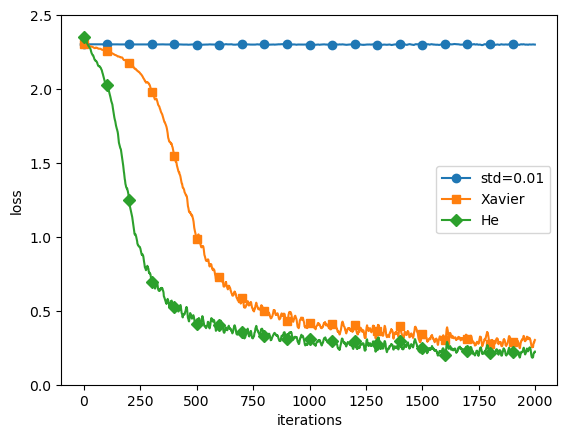

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


============== 1/16 ==============
epoch:0 | 0.116 - 0.109


c:\Users\howsi\OneDrive\vs_workspace\codingExer\stock_analysis\from_scratch\notes\common\functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x_ = x_ - C      # to prevent overflow


epoch:1 | 0.097 - 0.12
epoch:2 | 0.097 - 0.136
epoch:3 | 0.097 - 0.146
epoch:4 | 0.097 - 0.157
epoch:5 | 0.097 - 0.177
epoch:6 | 0.097 - 0.191
epoch:7 | 0.097 - 0.216
epoch:8 | 0.097 - 0.235
epoch:9 | 0.097 - 0.246
epoch:10 | 0.097 - 0.269
epoch:11 | 0.097 - 0.279
epoch:12 | 0.097 - 0.288
epoch:13 | 0.097 - 0.302
epoch:14 | 0.097 - 0.326
epoch:15 | 0.097 - 0.334
epoch:16 | 0.097 - 0.338
epoch:17 | 0.097 - 0.359
epoch:18 | 0.097 - 0.374


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.384
============== 2/16 ==============


c:\Users\howsi\OneDrive\vs_workspace\codingExer\stock_analysis\from_scratch\notes\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:0 | 0.117 - 0.083


c:\Users\howsi\OneDrive\vs_workspace\codingExer\stock_analysis\from_scratch\notes\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.079
epoch:2 | 0.097 - 0.102
epoch:3 | 0.097 - 0.115
epoch:4 | 0.097 - 0.137
epoch:5 | 0.097 - 0.163
epoch:6 | 0.097 - 0.186
epoch:7 | 0.097 - 0.199
epoch:8 | 0.097 - 0.222
epoch:9 | 0.097 - 0.24
epoch:10 | 0.097 - 0.259
epoch:11 | 0.097 - 0.291
epoch:12 | 0.097 - 0.313
epoch:13 | 0.097 - 0.334
epoch:14 | 0.097 - 0.349
epoch:15 | 0.097 - 0.365
epoch:16 | 0.097 - 0.394
epoch:17 | 0.097 - 0.417
epoch:18 | 0.097 - 0.434


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.438
============== 3/16 ==============
epoch:0 | 0.106 - 0.119
epoch:1 | 0.316 - 0.157
epoch:2 | 0.474 - 0.161
epoch:3 | 0.584 - 0.186
epoch:4 | 0.645 - 0.216
epoch:5 | 0.705 - 0.246
epoch:6 | 0.754 - 0.278
epoch:7 | 0.798 - 0.318
epoch:8 | 0.833 - 0.36
epoch:9 | 0.864 - 0.389
epoch:10 | 0.874 - 0.428
epoch:11 | 0.905 - 0.46
epoch:12 | 0.917 - 0.5
epoch:13 | 0.929 - 0.522
epoch:14 | 0.931 - 0.545
epoch:15 | 0.942 - 0.57
epoch:16 | 0.956 - 0.591
epoch:17 | 0.964 - 0.607
epoch:18 | 0.97 - 0.615


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.972 - 0.64
============== 4/16 ==============
epoch:0 | 0.089 - 0.1
epoch:1 | 0.306 - 0.096
epoch:2 | 0.438 - 0.164
epoch:3 | 0.545 - 0.249
epoch:4 | 0.6 - 0.31
epoch:5 | 0.648 - 0.363
epoch:6 | 0.686 - 0.405
epoch:7 | 0.718 - 0.447
epoch:8 | 0.743 - 0.5
epoch:9 | 0.764 - 0.542
epoch:10 | 0.777 - 0.574
epoch:11 | 0.794 - 0.61
epoch:12 | 0.805 - 0.651
epoch:13 | 0.811 - 0.674
epoch:14 | 0.833 - 0.709
epoch:15 | 0.823 - 0.724
epoch:16 | 0.854 - 0.743
epoch:17 | 0.85 - 0.757
epoch:18 | 0.871 - 0.77


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.868 - 0.779
============== 5/16 ==============
epoch:0 | 0.086 - 0.138
epoch:1 | 0.096 - 0.106
epoch:2 | 0.118 - 0.24
epoch:3 | 0.134 - 0.383
epoch:4 | 0.143 - 0.475
epoch:5 | 0.167 - 0.527
epoch:6 | 0.167 - 0.598
epoch:7 | 0.185 - 0.638
epoch:8 | 0.199 - 0.685
epoch:9 | 0.203 - 0.715
epoch:10 | 0.214 - 0.743
epoch:11 | 0.232 - 0.763
epoch:12 | 0.246 - 0.787
epoch:13 | 0.26 - 0.804
epoch:14 | 0.269 - 0.818
epoch:15 | 0.278 - 0.824
epoch:16 | 0.276 - 0.837
epoch:17 | 0.266 - 0.845
epoch:18 | 0.286 - 0.857


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.288 - 0.863
============== 6/16 ==============
epoch:0 | 0.124 - 0.077
epoch:1 | 0.189 - 0.237
epoch:2 | 0.172 - 0.423
epoch:3 | 0.146 - 0.54
epoch:4 | 0.179 - 0.638
epoch:5 | 0.181 - 0.694
epoch:6 | 0.183 - 0.745
epoch:7 | 0.116 - 0.775
epoch:8 | 0.116 - 0.802
epoch:9 | 0.116 - 0.821
epoch:10 | 0.116 - 0.849
epoch:11 | 0.116 - 0.866
epoch:12 | 0.116 - 0.882
epoch:13 | 0.116 - 0.897
epoch:14 | 0.116 - 0.906
epoch:15 | 0.116 - 0.91
epoch:16 | 0.117 - 0.919
epoch:17 | 0.116 - 0.931
epoch:18 | 0.118 - 0.937


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.126 - 0.943
============== 7/16 ==============
epoch:0 | 0.101 - 0.094
epoch:1 | 0.1 - 0.315
epoch:2 | 0.117 - 0.538
epoch:3 | 0.1 - 0.678
epoch:4 | 0.116 - 0.743
epoch:5 | 0.116 - 0.783
epoch:6 | 0.116 - 0.819
epoch:7 | 0.116 - 0.846
epoch:8 | 0.117 - 0.883
epoch:9 | 0.117 - 0.907
epoch:10 | 0.117 - 0.933
epoch:11 | 0.117 - 0.948
epoch:12 | 0.118 - 0.959
epoch:13 | 0.116 - 0.97
epoch:14 | 0.117 - 0.976
epoch:15 | 0.117 - 0.981
epoch:16 | 0.117 - 0.985
epoch:17 | 0.117 - 0.987
epoch:18 | 0.117 - 0.989


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.99
============== 8/16 ==============
epoch:0 | 0.116 - 0.135
epoch:1 | 0.116 - 0.312
epoch:2 | 0.116 - 0.64
epoch:3 | 0.117 - 0.756
epoch:4 | 0.117 - 0.82
epoch:5 | 0.117 - 0.852
epoch:6 | 0.117 - 0.885
epoch:7 | 0.117 - 0.899
epoch:8 | 0.117 - 0.922
epoch:9 | 0.117 - 0.945
epoch:10 | 0.117 - 0.961
epoch:11 | 0.117 - 0.968
epoch:12 | 0.117 - 0.983
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.116 - 0.085
epoch:1 | 0.116 - 0.556
epoch:2 | 0.116 - 0.719
epoch:3 | 0.116 - 0.79
epoch:4 | 0.116 - 0.845
epoch:5 | 0.116 - 0.877
epoch:6 | 0.117 - 0.929
epoch:7 | 0.117 - 0.958
epoch:8 | 0.116 - 0.978
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.992
epoch:11 | 0.117 - 0.996
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.998
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.1 - 0.217
epoch:1 | 0.117 - 0.577
epoch:2 | 0.117 - 0.786
epoch:3 | 0.117 - 0.833
epoch:4 | 0.117 - 0.879
epoch:5 | 0.117 - 0.938
epoch:6 | 0.117 - 0.94
epoch:7 | 0.117 - 0.97
epoch:8 | 0.117 - 0.971
epoch:9 | 0.117 - 0.981
epoch:10 | 0.117 - 0.968
epoch:11 | 0.117 - 0.992
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.992
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.1 - 0.119
epoch:1 | 0.116 - 0.571
epoch:2 | 0.116 - 0.673
epoch:3 | 0.116 - 0.779
epoch:4 | 0.116 - 0.896
epoch:5 | 0.116 - 0.938
epoch:6 | 0.116 - 0.909
epoch:7 | 0.116 - 0.946
epoch:8 | 0.116 - 0.957
epoch:9 | 0.116 - 0.98
epoch:10 | 0.116 - 0.96
epoch:11 | 0.116 - 0.969
epoch:12 | 0.116 - 0.979
epoch:13 | 0.116 - 0.97
epoch:14 | 0.116 - 0.89
epoch:15 | 0.116 - 0.992
epoch:16 | 0.116 - 0.982
epoch:17 | 0.116 - 0.992
epoch:18 | 0.116 - 0.995


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.995
============== 12/16 ==============
epoch:0 | 0.105 - 0.192
epoch:1 | 0.105 - 0.704
epoch:2 | 0.116 - 0.428
epoch:3 | 0.116 - 0.678
epoch:4 | 0.116 - 0.713
epoch:5 | 0.117 - 0.762
epoch:6 | 0.117 - 0.766
epoch:7 | 0.117 - 0.8
epoch:8 | 0.117 - 0.805
epoch:9 | 0.117 - 0.884
epoch:10 | 0.117 - 0.876
epoch:11 | 0.117 - 0.887
epoch:12 | 0.117 - 0.89
epoch:13 | 0.117 - 0.88
epoch:14 | 0.117 - 0.894
epoch:15 | 0.117 - 0.895
epoch:16 | 0.117 - 0.899
epoch:17 | 0.117 - 0.9
epoch:18 | 0.117 - 0.901


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.901
============== 13/16 ==============
epoch:0 | 0.105 - 0.145
epoch:1 | 0.116 - 0.312
epoch:2 | 0.116 - 0.54
epoch:3 | 0.116 - 0.694
epoch:4 | 0.116 - 0.757
epoch:5 | 0.116 - 0.773
epoch:6 | 0.116 - 0.773
epoch:7 | 0.116 - 0.772
epoch:8 | 0.116 - 0.793
epoch:9 | 0.116 - 0.809
epoch:10 | 0.116 - 0.805
epoch:11 | 0.116 - 0.803
epoch:12 | 0.116 - 0.8
epoch:13 | 0.116 - 0.701
epoch:14 | 0.116 - 0.791
epoch:15 | 0.116 - 0.857
epoch:16 | 0.116 - 0.886
epoch:17 | 0.116 - 0.883
epoch:18 | 0.116 - 0.893


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.893
============== 14/16 ==============
epoch:0 | 0.116 - 0.099
epoch:1 | 0.116 - 0.3
epoch:2 | 0.116 - 0.41
epoch:3 | 0.116 - 0.452
epoch:4 | 0.116 - 0.473
epoch:5 | 0.116 - 0.488
epoch:6 | 0.116 - 0.443
epoch:7 | 0.116 - 0.501
epoch:8 | 0.116 - 0.506
epoch:9 | 0.116 - 0.511
epoch:10 | 0.116 - 0.593
epoch:11 | 0.116 - 0.586
epoch:12 | 0.116 - 0.577
epoch:13 | 0.116 - 0.6
epoch:14 | 0.116 - 0.611
epoch:15 | 0.116 - 0.587
epoch:16 | 0.116 - 0.607
epoch:17 | 0.116 - 0.622
epoch:18 | 0.116 - 0.648


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.628
============== 15/16 ==============
epoch:0 | 0.116 - 0.099
epoch:1 | 0.116 - 0.192
epoch:2 | 0.116 - 0.273
epoch:3 | 0.117 - 0.375
epoch:4 | 0.117 - 0.435
epoch:5 | 0.117 - 0.422
epoch:6 | 0.117 - 0.426
epoch:7 | 0.117 - 0.428
epoch:8 | 0.117 - 0.454
epoch:9 | 0.117 - 0.398
epoch:10 | 0.117 - 0.478
epoch:11 | 0.117 - 0.492
epoch:12 | 0.117 - 0.494
epoch:13 | 0.117 - 0.492
epoch:14 | 0.117 - 0.52
epoch:15 | 0.117 - 0.519
epoch:16 | 0.117 - 0.523
epoch:17 | 0.117 - 0.522
epoch:18 | 0.117 - 0.523


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.523
============== 16/16 ==============
epoch:0 | 0.116 - 0.123
epoch:1 | 0.117 - 0.301
epoch:2 | 0.117 - 0.351
epoch:3 | 0.117 - 0.374
epoch:4 | 0.117 - 0.405
epoch:5 | 0.116 - 0.382
epoch:6 | 0.116 - 0.415
epoch:7 | 0.116 - 0.414
epoch:8 | 0.116 - 0.42
epoch:9 | 0.116 - 0.425
epoch:10 | 0.116 - 0.411
epoch:11 | 0.116 - 0.399
epoch:12 | 0.116 - 0.418
epoch:13 | 0.116 - 0.42
epoch:14 | 0.116 - 0.427
epoch:15 | 0.116 - 0.424
epoch:16 | 0.116 - 0.42
epoch:17 | 0.116 - 0.427
epoch:18 | 0.116 - 0.429
epoch:19 | 0.116 - 0.426


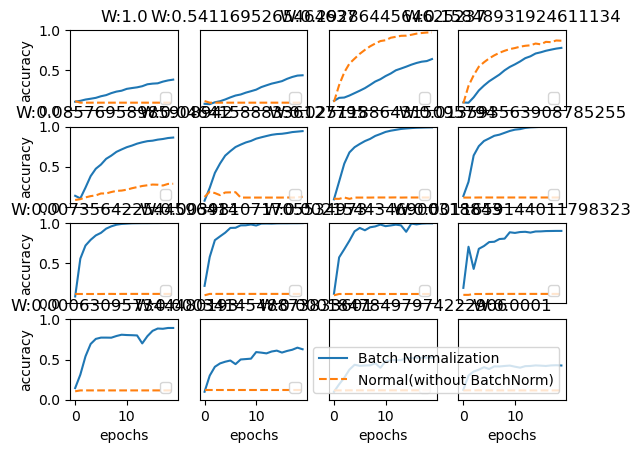

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()
